## 22227 - A Sai Kumar Reddy

In [3]:
%matplotlib inline

In [4]:
from google.colab import drive

# This will prompt you to authorize access to your Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data





In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crops a 224x224 portion from the image.
        transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally (left to right).
        transforms.ToTensor(),              #Converts the image into numbers (tensors) that our model can understand.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



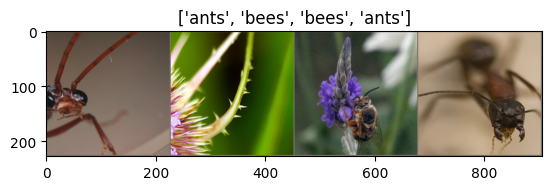

In [7]:
def imshow(inp, title=None):            #It takes the image (in Tensor format) and an optional title to display.
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))      #This line fetches a batch of training data (images and their corresponding labels) from the 'train' dataset.

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model




In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):   #Trains a machine learning model with given parameters.
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]: #Iterate through training and validation phases.
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [9]:
def visualize_model(model, num_images=6):  #This function visualizes the model's predictions on a few validation images.
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']): #Iterate through validation data.
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):  ## Iterate through the images in the batch
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [11]:
model_ft = models.resnet18(weights='IMAGENET1K_V1') #Load a pre-trained ResNet-18 model
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)  #(Stochastic Gradient Descent - SGD)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6986 Acc: 0.5533
val Loss: 0.5787 Acc: 0.6928

Epoch 1/24
----------
train Loss: 0.5505 Acc: 0.7172
val Loss: 0.4042 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4575 Acc: 0.8361
val Loss: 0.3228 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4198 Acc: 0.7951
val Loss: 0.2767 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4471 Acc: 0.7869
val Loss: 0.2631 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3775 Acc: 0.8525
val Loss: 0.2409 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4363 Acc: 0.8033
val Loss: 0.2409 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3978 Acc: 0.8197
val Loss: 0.2322 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3330 Acc: 0.8607
val Loss: 0.2366 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3432 Acc: 0.8607
val Loss: 0.2295 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3419 Acc: 0.8566
val Loss: 0.2277 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3656 Acc: 0.8279
val Loss: 0.2255 Acc: 0.9346

Ep

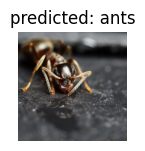

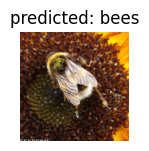

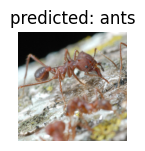

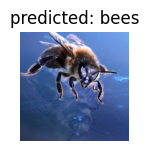

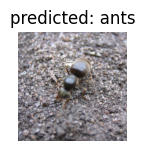

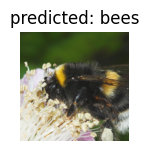

In [13]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [14]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)  #Modify the fully connected layer to match the desired number of classes (2 in this case)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6187 Acc: 0.6516
val Loss: 0.2542 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5243 Acc: 0.7664
val Loss: 0.2126 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.3464 Acc: 0.8648
val Loss: 0.1924 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5362 Acc: 0.7459
val Loss: 0.2379 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5033 Acc: 0.7828
val Loss: 0.1971 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3329 Acc: 0.8566
val Loss: 0.1554 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5920 Acc: 0.7787
val Loss: 0.2170 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.2895 Acc: 0.8566
val Loss: 0.1642 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4137 Acc: 0.8156
val Loss: 0.1768 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4031 Acc: 0.8320
val Loss: 0.1923 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3889 Acc: 0.8607
val Loss: 0.1623 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3124 Acc: 0.8648
val Loss: 0.2070 Acc: 0.9150

Ep

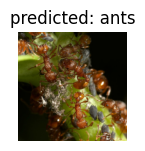

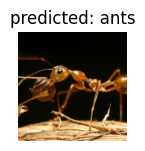

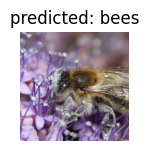

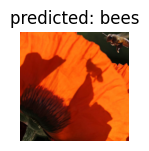

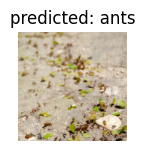

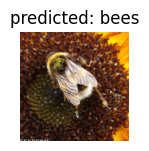

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [17]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)  ## Apply the transformation for validation data
    img = img.unsqueeze(0)  #Add a batch dimension
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

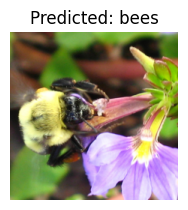

In [19]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/hymenoptera_data/hymenoptera_data/val/bees/1799729694_0c40101071.jpg'
)

plt.ioff()
plt.show()